In [1]:
!pip install accelerate peft bitsandbytes transformers trl


In [1]:
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer
import os

In [2]:
# first mention dataset name
#dataset="burkelibbey/colors"
dataset="bentrevett/multi30k"
# then specify model, we use chat for shorter trainer time, we will try base later
model_id="google/gemma-2b"
# define output directory
#output_model="tinyllama-colorist-v1"
output_model="gemma-2b-multi30k-v1-en-ger"

Don't run the next block if you want to use tinyllama

In [6]:
# model_id="Tyrannosaurus/TinyGPT-V"
# output_model="tinygpt"

# data prep

In [3]:
# we need to reformat the data in teh ChatML format.

def formatted_train(input,response)->str:
    return f"<bos><|im_start|>user\n{input}<|im_end|>\n<|im_start|>assistant\n{response}<|im_end|>\n"

In [4]:
# loads dataset with hugging face datasets
# turns the dataset into pandas dataframe
# picks the record from data frame
# then, adds the formatted instruction to tune. e.g., what the input is expected and what the output should be.
# lastly, returns a hugging face format dataset instead of a dataframe
# def prepare_train_data(data_id):
#     data = load_dataset(data_id, split="train")
#     data_df = data.to_pandas()
#     data_df["text"] = data_df[["description", "color"]].apply(lambda x: "<|im_start|>user\n" + x["description"] + " <|im_end|>\n<|im_start|>assistant\n" + x["color"] + "<|im_end|>\n", axis=1)
#     data = Dataset.from_pandas(data_df)
#     return data

def prepare_train_data_multi_30k(data_id):
    data = load_dataset(data_id, split="train")
    data_df = data.to_pandas()
    data_df["text"] = data_df[["de", "en"]].apply(lambda x: "<bos><|im_start|>user\n" + x["en"] + " <|im_end|>\n<|im_start|>assistant\n" + x["de"] + "<|im_end|>\n", axis=1)
    data = Dataset.from_pandas(data_df)
    return data

In [5]:
data = prepare_train_data_multi_30k(dataset)

In [6]:
data

Dataset({
    features: ['en', 'de', 'text'],
    num_rows: 29000
})

In [7]:
data[0] # notice the description, and the text

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'text': '<bos><|im_start|>user\nTwo young, White males are outside near many bushes. <|im_end|>\n<|im_start|>assistant\nZwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.<|im_end|>\n'}

In [4]:
def get_model_and_tokenizer(mode_id):
    # use tokenizer from llama2
    tokenizer = AutoTokenizer.from_pretrained('philschmid/gemma-tokenizer-chatml')
    tokenizer.pad_token = tokenizer.eos_token
    # uses bits and bytes package
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True
    )
    # loads the model
    model = AutoModelForCausalLM.from_pretrained(
        mode_id, quantization_config=bnb_config, device_map="auto"
    )
    model.config.use_cache=False
    model.config.pretraining_tp=1
    # returns a model and tokenizer
    return model, tokenizer

In [13]:
# !pip install -i https://test.pypi.org/simple/bitsandbytes

In [9]:
model, tokenizer = get_model_and_tokenizer(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

======== BELOW IS CODE FOR PHI2. Ignore it

In [15]:
#!pip install transformers==4.36

In [ ]:
# model = AutoModelForCausalLM.from_pretrained("susnato/phi-2")
# tokenizer = AutoTokenizer.from_pretrained("susnato/phi-2")

In [17]:
# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})
#     model.resize_token_embeddings(len(tokenizer))

============

In [13]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [14]:
# setup Lora configurations
peft_config = LoraConfig( # we can have different configurations, will test later
        r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    )

In [15]:
training_arguments = TrainingArguments(
        output_dir=output_model,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        optim="paged_adamw_32bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=10,
        num_train_epochs=1,
        #max_steps=1,
        fp16=True,
        # push_to_hub=True
    )

In [16]:
trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=1024
    )

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [17]:
torch.cuda.empty_cache() 

In [18]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: 7ammadi21 (7ammadi). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/906 [00:00<?, ?it/s]

{'loss': 4.2137, 'grad_norm': 2.4920570850372314, 'learning_rate': 0.0001999398868012663, 'epoch': 0.01}
{'loss': 2.6741, 'grad_norm': 1.4641607999801636, 'learning_rate': 0.00019975961947699846, 'epoch': 0.02}
{'loss': 2.2733, 'grad_norm': 1.052469253540039, 'learning_rate': 0.00019945941475610623, 'epoch': 0.03}
{'loss': 2.107, 'grad_norm': 1.0679720640182495, 'learning_rate': 0.00019903963356391057, 'epoch': 0.04}
{'loss': 1.9853, 'grad_norm': 1.127090334892273, 'learning_rate': 0.00019850078058821614, 'epoch': 0.06}
{'loss': 1.915, 'grad_norm': 0.8261127471923828, 'learning_rate': 0.00019784350367254322, 'epoch': 0.07}
{'loss': 1.9142, 'grad_norm': 0.8138351440429688, 'learning_rate': 0.0001970685930372489, 'epoch': 0.08}
{'loss': 1.8927, 'grad_norm': 0.7881177067756653, 'learning_rate': 0.00019617698032947366, 'epoch': 0.09}
{'loss': 1.8653, 'grad_norm': 0.7101891040802002, 'learning_rate': 0.00019516973750305532, 'epoch': 0.1}
{'loss': 1.8681, 'grad_norm': 0.7318605184555054, 'le

TrainOutput(global_step=906, training_loss=1.811098760853277, metrics={'train_runtime': 1112.9115, 'train_samples_per_second': 26.058, 'train_steps_per_second': 0.814, 'train_loss': 1.811098760853277, 'epoch': 1.0})

# Using Lora

In [10]:
from peft import AutoPeftModelForCausalLM, PeftModel
from transformers import AutoModelForCausalLM
import torch
import os

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, load_in_8bit=False,
                                             device_map="auto",
                                             trust_remote_code=True)

tokenizer = _, tokenizer = get_model_and_tokenizer(model_id)

#model_path = "/content/tinyllama-colorist-v1/checkpoint-250"
model_path = "gemma-2b-multi30k-v1-en-ger/checkpoint-906"

peft_model = PeftModel.from_pretrained(model, model_path, from_transformers=True, device_map="auto")

model = peft_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

# LLM Inference

In [8]:
from transformers import GenerationConfig
from time import perf_counter

def generate_response(user_input):

  prompt = formatted_prompt(user_input)

  inputs = tokenizer([prompt], return_tensors="pt")
  generation_config = GenerationConfig(penalty_alpha=0.6,do_sample = True,
      top_k=5,temperature=0.5,repetition_penalty=1.2,
      max_new_tokens=12,pad_token_id=tokenizer.eos_token_id
  )
  start_time = perf_counter()

  inputs = tokenizer(prompt, return_tensors="pt").to('cuda')

  outputs = model.generate(**inputs, generation_config=generation_config)
  output=tokenizer.decode(outputs[0], skip_special_tokens=True)
  #print(output)
  output_time = perf_counter() - start_time
  #print(f"Time taken for inference: {round(output_time,2)} seconds")
  return output

In [7]:
def formatted_prompt(question)-> str:
    return f"<bos><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant:"

In [21]:
data_test = load_dataset(dataset, split="test")

In [22]:
data_test

Dataset({
    features: ['en', 'de'],
    num_rows: 1000
})

In [47]:
data_test[0] # notice the description, and the text

{'en': 'A man in an orange hat starring at something.',
 'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}

In [23]:
import nltk
import pandas as pd
import re

In [49]:
#generate_response(user_input='color of black')

In [14]:
generate_response(user_input='A man with an orange hat is showing something to the camera while he was playing in the garden.')

'user\nA man with an orange hat is showing something to the camera while he was playing in the garden.\nassistant: Ein Mann mit einem orangen Hut zeigt etwas in die Kamera'

In [24]:
out=generate_response(user_input=data_test[0]['en'])
out=out.split('assistant:')[-1].strip()
# processed_out=re.sub("[^A-Za-z0-9., ]","",out)
print(out)

Ein Mann mit einem orangen Hut starrt auf etwas zu


In [25]:
input_en=[]
output_de=[]
gt_de=[]

for r in data_test:
  input_en.append(r["en"])
  out=generate_response(user_input=r["en"])
  out=str(out).split('assistant:')[-1].strip()
  #processed_out=re.sub("[^A-Za-z., ]","",out)
  output_de.append(out)
  gt_de.append(r["de"])

test_translation={
    'input_en':input_en,
    'output_de':output_de,
    "gt_de":gt_de
}
test_translation_df=pd.DataFrame(test_translation)
test_translation_df.to_csv('initial_attemtpt_gemma_multi30k_en_ger.csv')

In [26]:
from nltk.translate.bleu_score import corpus_bleu,  SmoothingFunction
from nltk.tokenize import word_tokenize
import csv
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('initial_attemtpt_gemma_multi30k_en_ger.csv')
# print if there are any nan values
print(df.isnull().sum())
# drop nan values
df = df.dropna()

Unnamed: 0    0
input_en      0
output_de     5
gt_de         0
dtype: int64


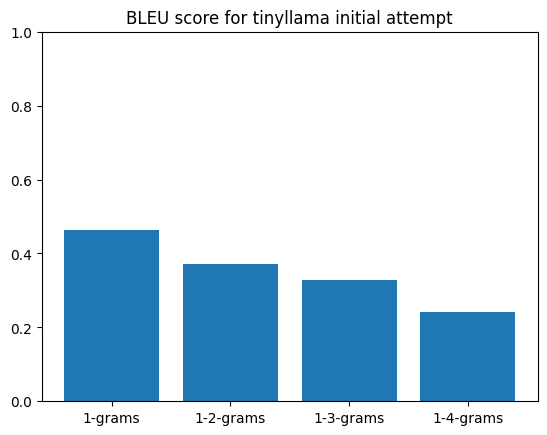

In [30]:
def bleu_score(csv_file):
  df_input=pd.read_csv(csv_file)
  df_input = df.dropna()
  actual, predicted=[],[]
  count=0
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["gt_de"].split()])
    predicted.append(r["output_de"].split())
  #print(actual)
  #print("===")
  #print(predicted)

  bleu_dic={}
  bleu_dic['1-grams']=corpus_bleu(actual, predicted, weights=(1.0,0,0,0))
  bleu_dic['1-2-grams']=corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0))
  bleu_dic['1-3-grams']=corpus_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
  bleu_dic['1-4-grams']=corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
  return bleu_dic

tinyllama_bleu=bleu_score('initial_attemtpt_gemma_multi30k_en_ger.csv')

plt.bar(x=tinyllama_bleu.keys(), height=tinyllama_bleu.values())
plt.title("BLEU score for tinyllama initial attempt")
plt.ylim((0,1))
plt.show()

In [22]:
tinyllama_bleu

{'1-grams': 0.5786995659176797,
 '1-2-grams': 0.4706711493253154,
 '1-3-grams': 0.41288084622307836,
 '1-4-grams': 0.3103266395412101}

In [34]:
from nltk.translate.bleu_score import sentence_bleu

def bleu_sent_score(csv_file):
  df_input=pd.read_csv(csv_file)
  df_input = df.dropna()
  actual, predicted=[],[]
  count=0
  scores = []
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["gt_de"].split()])
    predicted.append(r["output_de"].split())

    score = sentence_bleu([r["gt_de"].split()], r["output_de"].split())
    scores.append(score)



  return scores


tinyllama_bleu_sent=bleu_sent_score('initial_attemtpt_gemma_multi30k_en_ger.csv')
import numpy as np
np.array(tinyllama_bleu_sent).mean()
    

/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap

0.17536188299397273

In [ ]:
# pip install accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto")

input_text = "Write me a poem about Machine Learning."
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids)
print(tokenizer.decode(outputs[0]))


Meteor

In [36]:
import nltk
import numpy as np
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
df_input = pd.read_csv('initial_attemtpt_gemma_multi30k_en_ger.csv')
df_input = df_input.dropna()
actual, predicted = df_input['gt_de'], df_input['output_de']
scores=[]
for reference, hypothesis in zip(actual, predicted):
    tokenized_reference = word_tokenize(reference)
    tokenized_hypothesis = word_tokenize(hypothesis)
    scores.append(meteor_score([tokenized_reference], tokenized_hypothesis))

np.array(scores).mean()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/hamad.alhammadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0.4713225151668632

Comet

In [33]:
!pip install unbabel-comet

  Obtaining dependency information for unbabel-comet from https://files.pythonhosted.org/packages/6e/a1/ee4d2a587c4bcc2de344c1838353d0604bc3e905d5725920dab2218fb4a3/unbabel_comet-2.2.1-py3-none-any.whl.metadata
  Using cached unbabel_comet-2.2.1-py3-none-any.whl.metadata (15 kB)
  Obtaining dependency information for entmax<2.0,>=1.1 from https://files.pythonhosted.org/packages/06/a0/71747f0d98e441d0670b06205afd24d832e88c0ee62129ca47ce88505304/entmax-1.3-py3-none-any.whl.metadata
  Using cached entmax-1.3-py3-none-any.whl.metadata (348 bytes)
  Obtaining dependency information for jsonargparse==3.13.1 from https://files.pythonhosted.org/packages/04/cf/b8bdb5d6b631766a2332dca19cb2b214620a65c398636012dde69b71f36f/jsonargparse-3.13.1-py3-none-any.whl.metadata
  Using cached jsonargparse-3.13.1-py3-none-any.whl.metadata (55 kB)
  Obtaining dependency information for pytorch-lightning<3.0.0,>=2.0.0 from https://files.pythonhosted.org/packages/56/ed/192d7518b15a06452f480346eeebe1d1d4595af806

In [37]:
from evaluate import load
comet_metric = load("comet")
predicted = df_input['output_de']
actual = df_input['gt_de']
source = df_input['input_en']
results = comet_metric.compute(predictions=predicted, references=actual, sources=source)


/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hamad.alhammadi/.conda/envs/pytorch-intro/lib/ ...
GPU available: True (cuda), used: True
TPU available: Fa

In [38]:
results

{'mean_score': 0.6933862485178751,
 'scores': [0.8596979975700378,
  0.7343291640281677,
  0.7244001030921936,
  0.7781649231910706,
  0.5265653729438782,
  0.5423123240470886,
  0.9302451014518738,
  0.4683603346347809,
  0.6899112462997437,
  0.8971697688102722,
  0.8761208057403564,
  0.618414044380188,
  0.8235422968864441,
  0.8021829128265381,
  0.7874170541763306,
  0.5657564997673035,
  0.6673489212989807,
  0.5679261684417725,
  0.7537106871604919,
  0.7193638682365417,
  0.3792862892150879,
  0.627860963344574,
  0.9707560539245605,
  0.6234803795814514,
  0.6352798938751221,
  0.46950894594192505,
  0.9357201457023621,
  0.5241822600364685,
  0.8084094524383545,
  0.4315885901451111,
  0.8670313954353333,
  0.719157338142395,
  0.5522096753120422,
  0.7344309091567993,
  0.6858251690864563,
  0.4230331480503082,
  0.7471324801445007,
  0.6980739235877991,
  0.5412439703941345,
  0.4885619580745697,
  0.6364400386810303,
  0.5827838778495789,
  0.39961689710617065,
  0.754600